In [1]:
import glob
import pandas
import numpy
import os 

import matplotlib
import matplotlib.pyplot as plot

from plots import plot_boxes

from model_evaluation import bootstrap_metric

In [84]:
target_dir = 'results/'

data_load = None
for file_name in glob.glob(target_dir + '*'):
    if os.path.isfile(file_name):
        print('Loading...\t' + file_name)
        if data_load is None:
            data_load = pandas.read_pickle(file_name)
        else:
            data_load = pandas.concat([data_load,
                                       pandas.read_pickle(file_name)], 
                                      sort=False)

Loading...	results/sample_covariance_method_results
Loading...	results/svmr_local_identity_results
Loading...	results/svmr_global_identity_results


In [467]:
def plot_boxes(
        ax,
        plot_data,
        title,
        xlabel=None,
        ylabel=None,
        legend=None,
        xplot_labels=None,
        xplot_label_args=None,
        **kwargs):
    '''
    plot_boxes

    Plot single or multiple box plot using matplotlib
    '''
    ax.boxplot(plot_data, **kwargs)
    if xplot_labels is not None:
        ax.set_xticklabels(xplot_labels, **xplot_label_args)
    
    
    ax.set_title(title)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    if legend is not None:
        ax.legend(loc="best")

    return ax

def plot_lines(data, xcolumn, ycolumns, legend_column, legend_labels, colors, test=False):
    i = 0
    for lcol in data[legend_column].unique():
        for ycol in ycolumns:
            if test:
                print(lcol, ycol, legend_labels[i], colors[i])
                print(len(data.loc[data[legend_column] == lcol, ycol]))
                print(data.loc[data[legend_column] == lcol, [xcolumn, ycol]])                
            plot.plot(xcolumn, 
                      ycol, 
                      data=data[data[legend_column] == lcol], 
                      label=legend_labels[i],
                      color=colors[i])
            i += 1
            
            
def compute_bootstrap_median_quantiles(aggregate_data, data, alpha, groupby1, groupby2, aggregate_field):

    for gb1 in aggregate_data[groupby1].unique():
        for gb2 in aggregate_data[groupby2].unique():

            filtered_data = data.loc[(data[groupby2] == gb2) &
                                     (data[groupby1] == gb1),
                                     aggregate_field]

            if len(filtered_data) > 0:
                
                a, m, b = bootstrap_metric(data=filtered_data,
                                           metric_function=numpy.median,
                                           alpha=alpha,
                                           repetitions=1000,
                                           samples=len(filtered_data)*2,
                                           result_precision=10)

                aggregate_data.loc[(aggregate_data[groupby2] == gb2) &
                                   (aggregate_data[groupby1] == gb1),
                                   ' '.join([str(alpha/2), 'quantile'])] = a

                aggregate_data.loc[(aggregate_data[groupby2] == gb2) &
                                   (aggregate_data[groupby1] == gb1),
                                   ' '.join([str(1.0-(alpha/2)), 'quantile'])] = b
                
                aggregate_data.loc[(aggregate_data[groupby2] == gb2) &
                                   (aggregate_data[groupby1] == gb1),
                                   ' '.join([str(0.5), 'quantile'])] = m

    return aggregate_data

# Compare Differentially Private (DP) Sample Covarince / SVD methods

In [103]:
sample_cov_data = pandas.read_pickle('results/sample_covariance_method_results')

plot_fields = ['sample size', 'query', 'metric', 'result', 'mechanism runtime (s)']

sample_cov_plot_data = (sample_cov_data[plot_fields]
                        .groupby(by=['sample size','query', 'metric'])
                        .median()
                        .reset_index())
       
sample_cov_plot_data = compute_bootstrap_median_quantiles(aggregate_data=sample_cov_plot_data, 
                                                          data=sample_cov_data, 
                                                          alpha=0.05,
                                                          groupby1='query',
                                                          groupby2='sample size',
                                                          aggregate_field='result')      

In [121]:
sample_cov_plot_data[[
    'sample size', 
    'query', 
    'metric',
    'result', 
    '0.025 quantile', 
    '0.975 quantile',
    'mechanism runtime (s)'
]]

,sample size,query,metric,result,0.025 quantile,0.975 quantile,mechanism runtime (s)
0,20000,covariance,principal component RSS,0.070118,0.066097,0.077968,0.000474
1,20000,itentity,principal component RSS,0.397775,0.396027,0.399180,0.007805
2,100000,covariance,principal component RSS,0.002646,0.002525,0.002841,0.000484
3,100000,itentity,principal component RSS,0.398695,0.397052,0.399731,0.007762
4,350000,covariance,principal component RSS,0.000286,0.000260,0.000299,0.000482
5,350000,itentity,principal component RSS,0.398079,0.396392,0.399569,0.007831


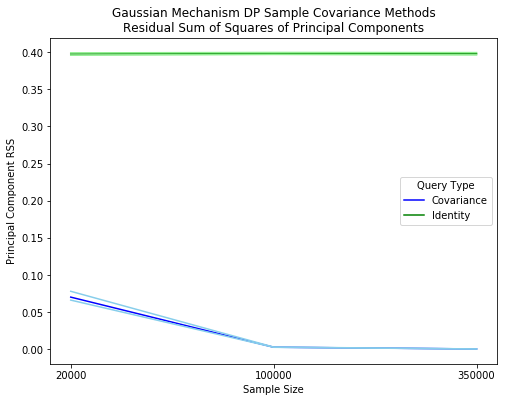

In [478]:
fig = plot.figure(figsize=(8,6))

sample_cov_plot_data = (sample_cov_plot_data
                        .assign(**{'sample size':sample_cov_plot_data['sample size']
                                                 .astype(str)}))
          
plot_lines(data=sample_cov_plot_data, 
           xcolumn='sample size', 
           ycolumns=['result', '0.025 quantile', '0.975 quantile'], 
           legend_column='query', 
           legend_labels=['Covariance', '_nolegend_', '_nolegend_', 'Identity', '_nolegend_', '_nolegend_'], 
           colors=['blue', 'skyblue', 'skyblue', 'green', 'lightgreen', 'lightgreen'])

plot.title('Gaussian Mechanism DP Sample Covariance Methods\nResidual Sum of Squares of Principal Components')
plot.xticks(sample_cov_plot_data['sample size'].unique())
plot.xlabel('Sample Size')
plot.ylabel('Principal Component RSS')
plot.legend(title='Query Type')
plot.show()


# Comparison of Private Data Release Methods 
## Evaluation by Support Vector Regression Test Holdout Error (RMSE)

In [375]:
SVMR_data = pandas.read_pickle('results/svmr_global_identity_results')

plot_fields = ['mechanism',
               'sample size', 
               'query',
               'result', 
               'mechanism runtime (s)']

SVMR_plot_data = (SVMR_data
                  .groupby(by=['sample size','mechanism'])
                  .median()
                  .reset_index())


SVMR_plot_data = compute_bootstrap_median_quantiles(aggregate_data=SVMR_plot_data, 
                                                    data=SVMR_plot_data,
                                                    alpha=0.05, 
                                                    groupby1='mechanism', 
                                                    groupby2='sample size',
                                                    aggregate_field='result')

SVMR_plot_data_str = (SVMR_plot_data
                      .assign(**{'sample size':SVMR_plot_data['sample size']
                                           .astype(str)}))

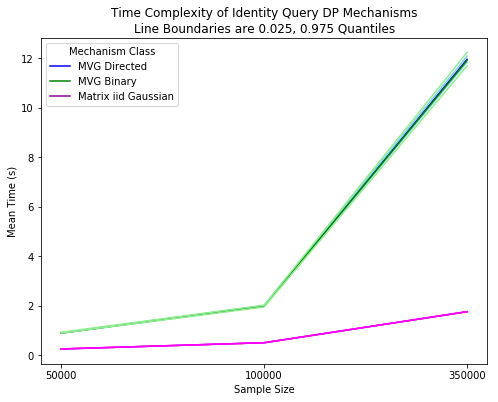

In [479]:

colors = [
    'orange', 
    'green', 
    'purple'
]

SVMR_local_data = pandas.read_pickle('results/svmr_local_identity_results')

SVMR_plot_data = (SVMR_local_data
                  .groupby(by=['sample size','mechanism'])
                  .median()
                  .reset_index())


SVMR_plot_data_str = (SVMR_plot_data
                      .assign(**{'sample size':SVMR_plot_data['sample size']
                                               .astype(str)}))


SVMR_plot_data_str.loc[SVMR_plot_data_str.mechanism.str.contains(r'mvg directed'), 'mechanism class'] = 'MVG Directed'
SVMR_plot_data_str.loc[SVMR_plot_data_str.mechanism.str.contains(r'mvg 0'), 'mechanism class'] = 'MVG Binary'
SVMR_plot_data_str.loc[SVMR_plot_data_str.mechanism.str.contains(r'matrix iid gaussian'), 'mechanism class'] = 'Matrix iid Gaussian' 
SVMR_plot_data_str.loc[SVMR_plot_data_str.mechanism == 'baseline','mechanism class'] = 'Baseline'

mechanism_class_values = [
    'MVG Directed',
    'MVG Binary',
    'Matrix iid Gaussian'
]


SVMR_timing_data = (SVMR_plot_data_str
                    .groupby(by=['sample size','mechanism class'])
                    .median()
                    .reset_index())

SVMR_timing_data = compute_bootstrap_median_quantiles(aggregate_data=SVMR_timing_data, 
                                                        data=SVMR_plot_data_str, 
                                                        alpha=0.05,
                                                        groupby1='mechanism class',
                                                        groupby2='sample size',
                                                        aggregate_field='mechanism runtime (s)')   


SVMR_timing_data = pandas.concat([SVMR_timing_data[SVMR_timing_data['sample size'] == '50000'],
                                  SVMR_timing_data[SVMR_timing_data['sample size'] == '100000'],
                                  SVMR_timing_data[SVMR_timing_data['sample size'] == '350000']])

labels = (SVMR_timing_data
          .loc[SVMR_timing_data['mechanism class']
               .isin(mechanism_class_values), 'mechanism class']
          .unique())

fig = plot.figure(figsize=(8,6))        
            
plot_lines(data=SVMR_timing_data[SVMR_timing_data['mechanism class'].isin(mechanism_class_values)], 
           xcolumn='sample size', 
           ycolumns=['mechanism runtime (s)', '0.025 quantile', '0.975 quantile'], 
           legend_column='mechanism class', 
           legend_labels=['MVG Directed', '_nolegend_', '_nolegend_', 
                          'MVG Binary', '_nolegend_', '_nolegend_',
                          'Matrix iid Gaussian', '_nolegend_', '_nolegend_'], 
           colors=['blue', 'skyblue', 'skyblue', 
                   'green', 'lightgreen', 'lightgreen',
                   'darkmagenta', 'magenta', 'magenta'],
           test=False)

plot.legend(title='Mechanism Class')
plot.title('Time Complexity of Identity Query DP Mechanisms\nLine Boundaries are 0.025, 0.975 Quantiles')
plot.xlabel('Sample Size')
plot.ylabel('Mean Time (s)')

plot.show()

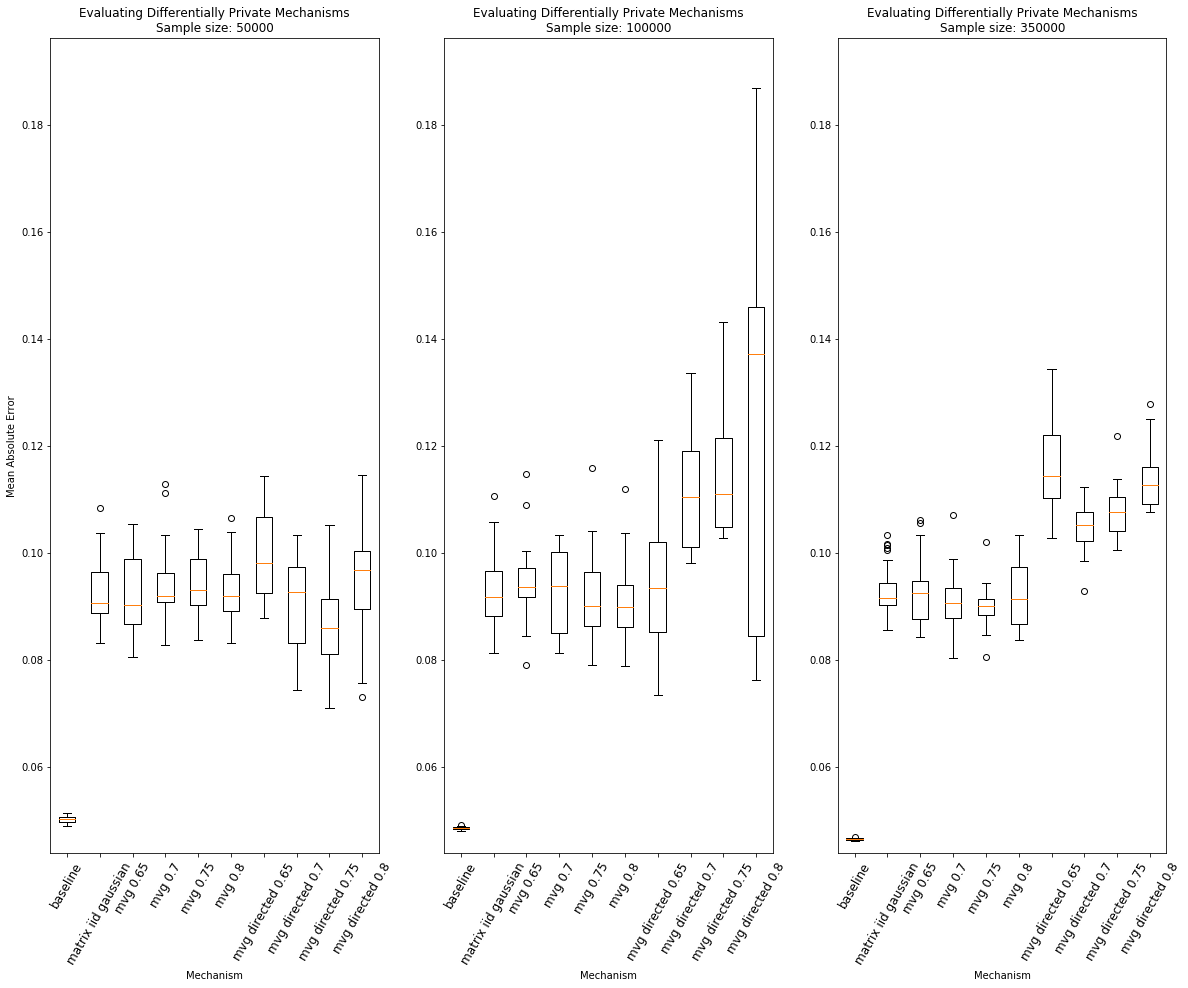

In [449]:
mechanism_values = [
    'baseline',
    'matrix iid gaussian',
    'mvg 0.65',
    'mvg 0.7', 
    'mvg 0.75',
    'mvg 0.8',
    'mvg directed 0.65',
    'mvg directed 0.7', 
    'mvg directed 0.75',
    'mvg directed 0.8',
]

# Collect data and labels
boxplot_labels = SVMR_data['mechanism'].unique()
boxplot_data = dict()
    
for sample_size in sorted(SVMR_data['sample size'].unique()):
    if sample_size in [50000, 100000, 350000]:
#         print(sample_size)
        boxplot_data[sample_size] = [
            SVMR_data.loc[
                (SVMR_data['sample size'] == sample_size) &
                (SVMR_data['mechanism'] == mechanism), 
                'result'].values 
            for mechanism in mechanism_values
        ]
    
# Boxplot of experiment RMSE results 
boxplot_args = dict(notch=False,bootstrap=1000)

fig, ax = plot.subplots(1,3)

fig.set_figheight(15)
fig.set_figwidth(20)


ylabel_graphs = [0,3];

min_y = numpy.min([ numpy.min(x) for x in numpy.ravel(boxplot_data.values())])*0.95
max_y = numpy.max([ numpy.max(x) for x in numpy.ravel(boxplot_data.values())])*1.05

for i, ss in enumerate(sorted(boxplot_data.keys())):
   
    ax[i].set_ylim(min_y, max_y)

    if i in ylabel_graphs:
        ylabel = 'Mean Absolute Error'
    else:
        ylabel = None
        
    plot_boxes(
            ax=ax[i%3],
            title='Evaluating Differentially Private Mechanisms\nSample size: ' + str(ss),
            xlabel='Mechanism',
            ylabel=ylabel,
            xplot_labels=mechanism_values,
            plot_data=boxplot_data[ss],
            xplot_label_args=dict(rotation=60, fontsize=12),
            **boxplot_args)

fig.show()


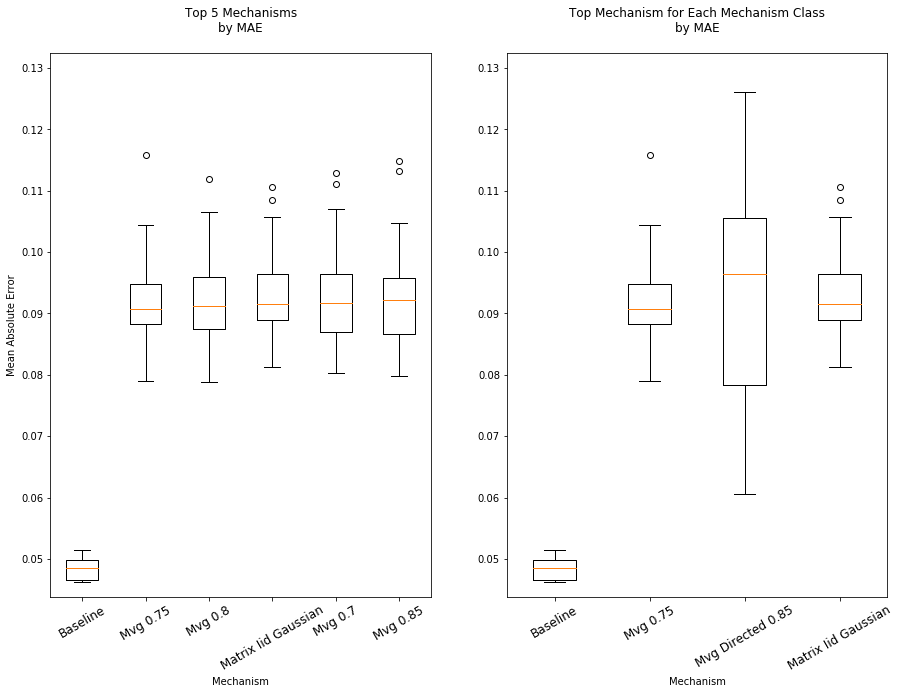

In [473]:
boxplot_args = dict(notch=False,bootstrap=1000)

fig, ax = plot.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(15)

top_5_mvg_data = (
    SVMR_data
    .groupby(['mechanism'])
    .median()
    .sort_values('result')
    .head(6)
    .reset_index()
)

plot_mechanisms = numpy.append(top_5_mvg_data.mechanism.unique(), top_by_mechanism_class.mechanism.unique())

top_5_mechanisms_boxplot = [
    SVMR_data.loc[SVMR_data['mechanism'] == mechanism, 'result'].values
    for mechanism in top_5_mvg_data.mechanism.unique()
]

labels = [ s.title() for s in top_5_mvg_data.mechanism.unique()]

min_y = SVMR_data.loc[SVMR_data.mechanism.isin(plot_mechanisms), 'result'].min()*0.95
max_y = SVMR_data.loc[SVMR_data.mechanism.isin(plot_mechanisms), 'result'].max()*1.05

ax[0].set_ylim(min_y, max_y)

plot_boxes(
    ax=ax[0],
    title='Top 5 Mechanisms\nby MAE\n',
    xlabel='Mechanism',
    ylabel='Mean Absolute Error',
    xplot_labels=labels,
    plot_data=top_5_mechanisms_boxplot,
    xplot_label_args=dict(rotation=30, fontsize=12),
    **boxplot_args)


SVMR_data_str = (SVMR_data
                .assign(**{'sample size':SVMR_data['sample size']
                                         .astype(str)}))

SVMR_data_str.loc[SVMR_data_str.mechanism.str.contains(r'mvg directed'), 'mechanism class'] = 'MVG Directed'
SVMR_data_str.loc[SVMR_data_str.mechanism.str.contains(r'mvg 0'), 'mechanism class'] = 'MVG Binary'
SVMR_data_str.loc[SVMR_data_str.mechanism.str.contains(r'matrix iid gaussian'), 'mechanism class'] = 'Matrix iid Gaussian' 
SVMR_data_str.loc[SVMR_data_str.mechanism == 'baseline','mechanism class'] = 'Baseline'


top_by_mechanism_class = (
    SVMR_data_str.loc[:,['sample size',
                     'mechanism class',
                     'mechanism',
                     'result']]
    .dropna()
    .groupby(['mechanism','mechanism class'])
    .median()
    .sort_values(['mechanism class','result'])
    .groupby('mechanism class')
    .head(1)
    .reset_index()
)

top_by_mechanism_class_boxplot = [
    SVMR_data_str.loc[SVMR_data_str['mechanism'] == mechanism, 'result'].values
    for mechanism in top_by_mechanism_class.mechanism.unique()
]

labels = [ s.title() for s in top_by_mechanism_class.mechanism.unique()]

ax[1].set_ylim(min_y, max_y)

plot_boxes(
    ax=ax[1],
    title='Top Mechanism for Each Mechanism Class\nby MAE\n',
    xlabel='Mechanism',
    ylabel=None,
    xplot_labels=labels,
    plot_data=top_by_mechanism_class_boxplot,
    xplot_label_args=dict(rotation=30, fontsize=12),
    **boxplot_args)